In [1]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 1.2 MB/s eta 0:00:00


In [2]:
import patoolib

In [3]:
patoolib.extract_archive("/content/data.zip")

INFO patool: Extracting /content/data.zip ...
INFO:patool:Extracting /content/data.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_43rdz19g -- /content/data.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_43rdz19g -- /content/data.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/data.zip extracted to `data'.
INFO:patool:... /content/data.zip extracted to `data'.


'data'

In [4]:
import os
import zipfile
from glob import glob
from pathlib import Path

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import skimage
from matplotlib import colors
from scipy.optimize import linear_sum_assignment
from skimage.measure import label
from skimage.metrics import contingency_table, peak_signal_noise_ratio
from skimage.segmentation import find_boundaries, watershed
from skimage.util import random_noise
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def draw_plot(x_data, y_data, x_label, y_label, legend_one, legend_two, title):

    fig, ax = plt.subplots()

    line_one, = ax.plot(x_data, y_data[0], label = legend_one, linestyle = "--", marker = "o")
    line_two, = ax.plot(x_data, y_data[1], label = legend_two, linestyle = "--", marker = "o")

    ax.legend(handles = [line_one, line_two], fontsize = 12)

    plt.title(title, fontsize = 18)
    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(y_label, fontsize = 14)

    plt.show()

In [7]:
# create a root folder where to save the data for this exercise in Kaggle
# root_folder = "D:\STUDY\DS\PyLab\ml\data"
# root_folder = "/kaggle/working/dlforcv-ex5"
root_folder = "/content/data"
os.makedirs(root_folder, exist_ok=True)

In [8]:
image_paths = glob(os.path.join(root_folder, "images", "*.tif"))
image_paths.sort()
mask_paths = glob(os.path.join(root_folder, "masks", "*.tif"))
mask_paths.sort()
assert len(image_paths) == len(mask_paths)

In [9]:
# a function to generate a random color map for a label image
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap

In [10]:
def plot_sample(image_path, mask_path):
    image, mask = imageio.imread(image_path), imageio.imread(mask_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(image, cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

In [11]:
# plot the first 4 images
for i in range(8):
    print(image_paths[i], mask_paths[i])

/content/data/images/ID_0000_Z_0142.tif /content/data/masks/ID_0000_Z_0142.tif
/content/data/images/ID_0001_Z_0146.tif /content/data/masks/ID_0001_Z_0146.tif
/content/data/images/ID_0002_Z_0162.tif /content/data/masks/ID_0002_Z_0162.tif
/content/data/images/ID_0003_Z_0132.tif /content/data/masks/ID_0003_Z_0132.tif
/content/data/images/ID_0004_Z_0066.tif /content/data/masks/ID_0004_Z_0066.tif
/content/data/images/ID_0005_Z_0066.tif /content/data/masks/ID_0005_Z_0066.tif
/content/data/images/ID_0006_Z_0206.tif /content/data/masks/ID_0006_Z_0206.tif
/content/data/images/ID_0007_Z_0211.tif /content/data/masks/ID_0007_Z_0211.tif


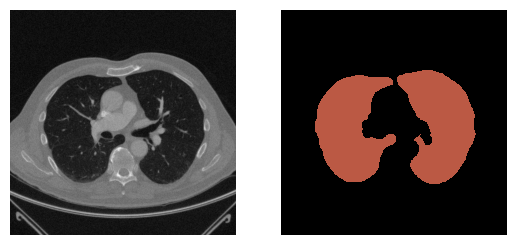

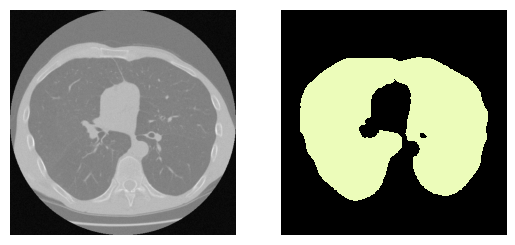

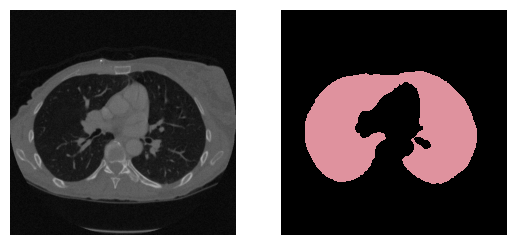

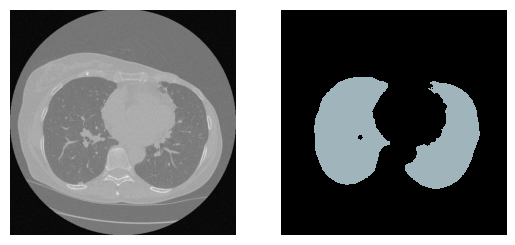

In [12]:
# plot the first 4 images
for i in range(4):
    plot_sample(image_paths[i], mask_paths[i])

In [13]:
# TODO find how many images we have in the training set
# and find all (unique) shapes of the images in the training set
print(len(image_paths))
training_set = [imageio.imread(f) for f in image_paths]

# Create a set to store the unique shapes
shapes = set()

# Iterate through the images and add their shapes to the set
for img in training_set:
  shapes.add(img.shape)

# Print the unique shapes
print(shapes)


267
{(512, 512)}


In [14]:
# TODO now load the images and masks into memory, and normalize the images so that they have zero mean and unit variance
images = []
masks = []

for image_path in image_paths:
    # Open the image and convert it to a numpy array
    image = imageio.imread(image_path)
    image = np.array(image)
    image =  image.astype(np.float32)
    images.append(image)

for mask_path in mask_paths:
    # Open the image and convert it to a numpy array
    mask = imageio.imread(mask_path)
    mask = np.array(mask)
    masks.append(mask)

In [15]:
# Flatten and concatenate all images
flattened_images = np.concatenate([image.flatten() for image in images])
# Calculate mean and standard deviation
mean = np.mean(flattened_images)
std = np.std(flattened_images)
normalized_images = [(image - mean) / std for image in images]#Whole Dataset
images = [(im.astype("float32") - np.mean(im)) / np.std(im) for im in normalized_images]#Image by image

In [16]:
#Test Train split
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
t_images, test_images, t_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [17]:
def plot_test_train(image, mask):
    # image, mask = imageio.imread(image_path), imageio.imread(mask_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(image, cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

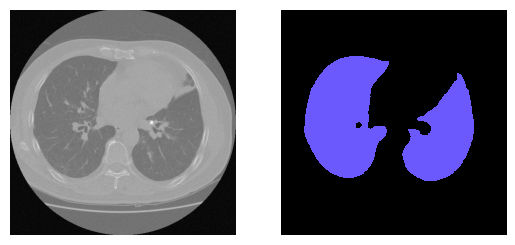

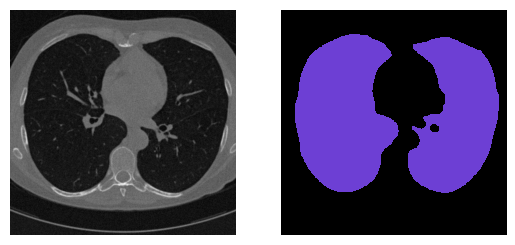

In [18]:
# plot the first 2 images
for i in range(2):
    plot_test_train(t_images[i], t_masks[i])

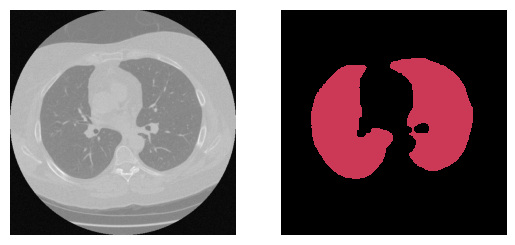

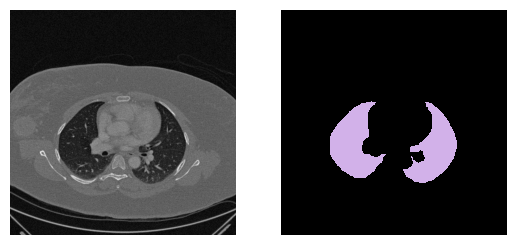

In [19]:
# plot the first 2 images
for i in range(2):
    plot_test_train(test_images[i], test_masks[i])

In [20]:
len(t_images)

213

In [21]:
# TODO make a train validation split, use every 20th image for validation
train_images = [image for i, image in enumerate(t_images) if i==0 or i % 19 != 0]
train_masks = [mask for i, mask in enumerate(t_masks) if i==0 or i % 19 != 0]
val_images = [image for i, image in enumerate(t_images) if i!=0 and i % 19 == 0]
val_masks = [mask for i, mask in enumerate(t_masks) if i!=0 and i % 19 == 0]

In [42]:
import random
from torchvision.transforms import functional as TF

In [38]:
# class NucleiDataset(Dataset):
#     def __init__(self, images, masks, image_transform=None, mask_transform=None, transform=None):
#         assert len(images) == len(masks)
#         self.images = images
#         self.masks = masks
#         self.image_transform = image_transform
#         self.mask_transform = mask_transform
#         self.transform = transform
#         # Define image and mask transformations
#         self.image_augment = transforms.Compose([
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             # Add more transformations as needed
#         ])

#         # Usually, for masks, we only apply geometric transformations
#         self.mask_augment = transforms.Compose([
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             # Add more transformations as needed
#         ])

#     def transform(self, image, mask):
#         # Combined transform for both image and mask
#         if self.image_augment is not None:
#             image = self.image_augment(image)

#         # Random horizontal flipping
#         if random.random() > 0.5:
#             image = TF.hflip(image)
#             mask = TF.hflip(mask)

#         # Random vertical flipping
#         if random.random() > 0.5:
#             image = TF.vflip(image)
#             mask = TF.vflip(mask)

#         # Additional transforms can be added here

#         return image, mask

#     def __getitem__(self, index):
#         image, mask = self.images[index], self.masks[index]

#         # crop the images to have the shape 256 x 256, so that we can feed them into memory
#         # despite them having different sizes
#         crop_shape = (512, 512)
#         shape = image.shape
#         if shape != crop_shape:
#             assert image.ndim == mask.ndim == 2
#             crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
#             crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
#             image, mask = image[crop], mask[crop]

#         # Convert numpy arrays to PIL Images for applying torchvision transforms
#         image, mask = Image.fromarray(image), Image.fromarray(mask)

#     # Random seed for synchronizing transformations
#         seed = np.random.randint(2147483647)
#         random.seed(seed)  # Apply this seed for random transforms
#         torch.manual_seed(seed)

#         # Apply augmentations
#         if self.image_augment is not None:
#             image = self.image_augment(image)
#         if self.mask_augment is not None:
#             mask = self.mask_augment(mask)

#         # Apply any additional transforms
#         if self.image_transform is not None:
#             image = self.image_transform(image)
#         if self.mask_transform is not None:
#             mask = self.mask_transform(mask)
#         if self.transform is not None:
#             image, mask = self.transform(image, mask)

#         # Convert to numpy arrays and add a channel dimension if necessary
#         image, mask = np.array(image, dtype=np.float32), np.array(mask, dtype=np.float32)
#         if image.ndim == 2:
#             image = image[None]
#         if mask.ndim == 2:
#             mask = mask[None]

#         return image, mask

#     def __len__(self):
#         return len(self.images)

In [43]:
class NucleiDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Define image and mask transformations
        self.image_augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            
        ])

        # Usually, for masks, we only apply geometric transformations
        self.mask_augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
           
        ])

    def transform(self, image, mask):
        # Apply random seed for synchronized transformations
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)

        # Apply geometric transformations
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Apply additional transforms specific to images
        if self.image_transform is not None:
            image = self.image_transform(image)

        # Convert mask to binary after geometric transformations
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return image, mask

    def __getitem__(self, index):
        image, mask = self.images[index], self.masks[index]

        # Crop if necessary (adjust the crop_shape as needed)
        crop_shape = (512, 512)
        if image.shape != crop_shape:
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(image.shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            image, mask = image[crop], mask[crop]

        # Convert numpy arrays to PIL Images
        image, mask = Image.fromarray(image), Image.fromarray(mask)

        # Apply transformations
        image, mask = self.transform(image, mask)

        # Convert to numpy arrays and add a channel dimension if necessary
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.float32)
        if image.ndim == 2:
            image = image[None]
        if mask.ndim == 2:
            mask = mask[None]

        return image, mask

    def __len__(self):
        return len(self.images)

In [44]:
# TODO implement a transform that outputs the binary target
# and instantiate the training dataset and validation dataset with it
# HINT: the transform can be a function that takes the mask array as input and returns the binarized version
# HINT: you will also need to add a channel dimension to the target
# def binary_transform(mask):
#     # Binarize the mask
#     binary_mask = (mask > 0).astype(np.float32)
#     # Add a channel dimension
#     binary_mask = np.expand_dims(binary_mask, axis=0)
#     return binary_mask
def binary_transform(mask):
    # Convert PIL Image to numpy array if it's not already
    if isinstance(mask, Image.Image):
        mask = np.array(mask)

    # Binarize the mask
    binary_mask = (mask > 0).astype(np.float32)
    # Add a channel dimension
    binary_mask = np.expand_dims(binary_mask, axis=0)

    return binary_mask

In [45]:
# instantiate the training and validation datasets with the new label transform
train_dataset = NucleiDataset(
    train_images, train_masks, mask_transform=binary_transform
)
val_dataset = NucleiDataset(
    val_images, val_masks, mask_transform=binary_transform
)

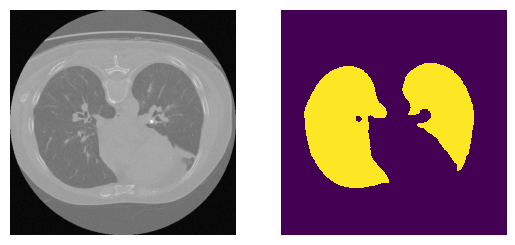

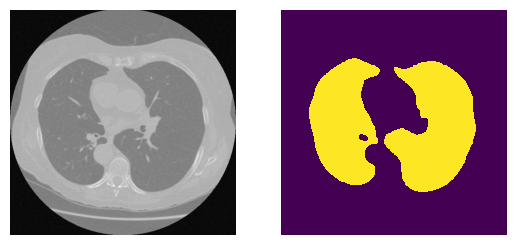

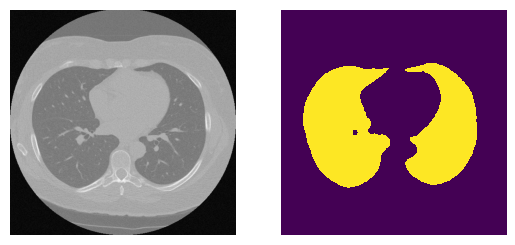

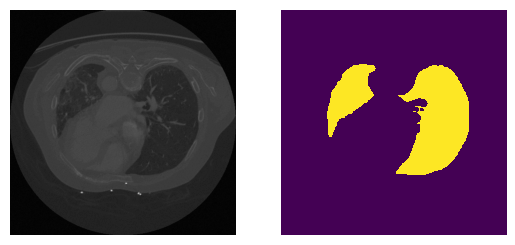

In [46]:
# TODO sample a few images from the dataset and verify that they are correct
s= 0
for i in range(4):
    j,k = train_dataset[s]
    j = np.transpose(j, axes=[1, 2, 0])
    k = np.transpose(k, axes=[1, 2, 0])
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(j, cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(k, interpolation="nearest")
    plt.show()
    s = s+8



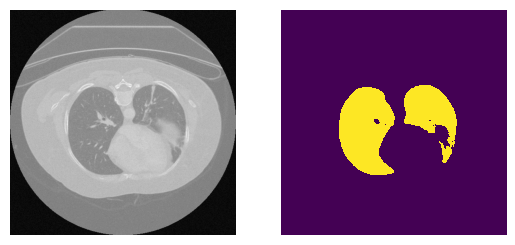

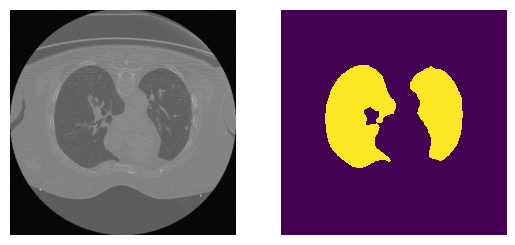

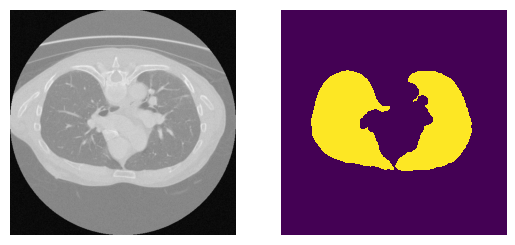

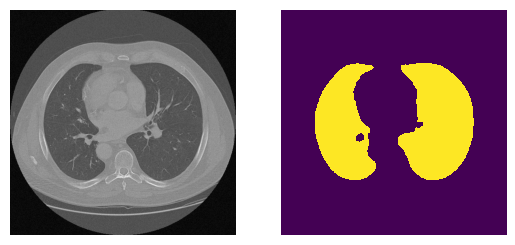

In [47]:
see = 5
for i in range(4):
    j,k = train_dataset[see]
    j = np.transpose(j, axes=[1, 2, 0])
    k = np.transpose(k, axes=[1, 2, 0])
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(j, cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(k, interpolation="nearest")
    plt.show()
    see = see + i + 7

In [48]:
class ConvolutionUnit(nn.Module):
    def __init__(self, ins, outs, kernel_size=3, dilation_rate=1, dropout_rate=0.5):
        super(ConvolutionUnit, self).__init__()
        padding = ((kernel_size - 1) * dilation_rate) // 2
        self.conv1 = nn.Conv2d(ins, outs, kernel_size=kernel_size, padding=padding, dilation=dilation_rate)
        self.bn1 = nn.BatchNorm2d(outs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(outs, outs, kernel_size=kernel_size, padding=padding, dilation=dilation_rate)
        self.bn2 = nn.BatchNorm2d(outs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return x

class DownSamplingBlock(nn.Module):
    def __init__(self, channels=[3, 64, 128, 256, 512, 1024], dilation_rates=[1, 1, 1, 1, 1]):
        super(DownSamplingBlock, self).__init__()

        self.encoder_layers = nn.ModuleList([
            ConvolutionUnit(channels[i], channels[i+1], dilation_rate=dilation_rates[i]) for i in range(len(channels)-1)
        ])
        self.down_sampling_layer = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        encoded_features = []
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
            encoded_features.append(x)
            x = self.down_sampling_layer(x)
        return encoded_features

class UpSamplingBlock(nn.Module):
    def __init__(self, channels=[1024, 512, 256, 128, 64]):
        super(UpSamplingBlock, self).__init__()

        self.decoder_layers = nn.ModuleList([
            ConvolutionUnit(channels[i], channels[i+1]) for i in range(len(channels) - 1)
        ])

        self.up_sampling_layers = nn.ModuleList([
            nn.ConvTranspose2d(channels[i], channels[i+1], kernel_size=2, stride=2) for i in range(len(channels) - 1)
        ])

    def forward(self, x, encoded_features):
        for i in range(len(self.decoder_layers)):
            x = self.up_sampling_layers[i](x)
            # Resize or crop the encoded feature to match x's size
            encoded_feature = F.interpolate(encoded_features[i], size=x.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat([x, encoded_feature], dim=1)
            x = self.decoder_layers[i](x)
        return x

class Unet(nn.Module):
    def __init__(self, encoder_channels=[3, 64, 128, 256, 512, 1024], decoder_channels=[1024, 512, 256, 128, 64], num_classes=1, out_size=(512, 512)):
        super(Unet, self).__init__()

        self.out_size = out_size
        self.down_sampler = DownSamplingBlock(encoder_channels)
        self.up_sampler = UpSamplingBlock(decoder_channels)
        self.final_layer = nn.Conv2d(in_channels=decoder_channels[-1], out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        encoded_features = self.down_sampler(x)
        # Reverse and convert to list
        reversed_features = list(reversed(encoded_features[:-1]))
        decoded_features = self.up_sampler(encoded_features[-1], reversed_features)
        output = self.final_layer(decoded_features)
        output = F.interpolate(output, self.out_size)
        return output

In [49]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
sample = iter(train_loader)
samples , labels = next(sample)
s =samples.to(device)


In [50]:
# TODO instantiate a unet and check that your architecture is correct by applying it to
# an input from the train loader
model_2 = torch.nn.DataParallel(Unet(
    encoder_channels=[1, 64, 128, 256, 512, 1024],
    decoder_channels=[1024, 512, 256, 128, 64])).to(device)

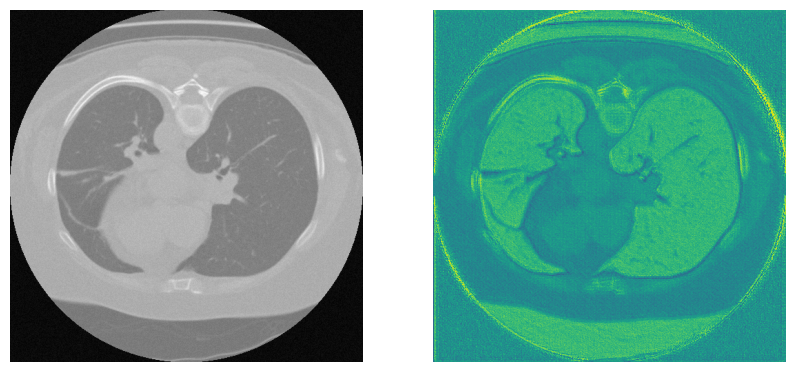

In [51]:
# TODO display the prediction. Can you interpret the resulting image?
value = model_2(s)
pred = value.squeeze()
pred = torch.sigmoid(pred).cpu().detach().numpy()
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].axis("off")
ax[0].imshow(np.transpose(samples[0], axes=[1, 2, 0]), cmap="gray")
ax[1].axis("off")
ax[1].imshow(pred)
plt.show()

In [52]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [53]:
model = Unet(
    encoder_channels=[1, 64, 128, 256, 512, 1024],
    decoder_channels=[1024, 512, 256, 128, 64]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [54]:
def normalize(tensor):
  eps = 1e-6
  normed = tensor.numpy()
  minval = normed.min(axis=(0, 2, 3), keepdims=True)
  normed = normed - minval
  maxval = normed.max(axis=(0, 2, 3), keepdims=True)
  normed = normed / (maxval + eps)
  return torch.from_numpy(normed)

# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    Tloss = 0
    metric_val = []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x = x.float()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        if metric is not None:
            metric_value = metric(pred, y)
            metric_val.append(metric_value.item())
        Tloss += loss_value.item()
        if metric is not None:
            metric_mean = sum(metric_val) / len(metric_val)
        else:
            metric_mean = 0


    return  Tloss/len(loader),metric_mean


# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    n_val = len(loader)
    metric_value, loss_value = 0.0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.float()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value += loss(pred, y).item()
            if metric is not None:
                metric_value += metric(pred, y).item()

    metric_value /= n_val
    loss_value /= n_val
    return loss_value,metric_value

# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs
):
    epoch_len = len(train_loader)
    step = 0
    t_loss = []
    v_loss = []
    t_ms =[]
    v_ms = []
    for epoch in tqdm.trange(n_epochs):
        a,a_m = train_epoch(model, train_loader, loss, metric, optimizer)
        step = epoch_len * (epoch + 1)
        b,b_m =validate(model, val_loader, loss, metric)
        scheduler.step(b)
        t_loss.append(a)
        v_loss.append(b)
        t_ms.append(a_m)
        v_ms.append(b_m)
    return t_loss, v_loss,t_ms,v_ms


In [55]:
# TODO create the loss function
# loss= nn.BCEWithLogitsLoss()
class CombinedBCEAndDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def dice_loss(self, input, target):
        input = torch.sigmoid(input)
        smooth = 1e-6
        input_flat = input.view(-1)
        target_flat = target.view(-1)
        intersection = (input_flat * target_flat).sum()
        dice_score = (2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        return 1 - dice_score

    def forward(self, input, target):
        bce = self.bce_loss(input, target)
        dice = self.dice_loss(input, target)
        return self.bce_weight * bce + self.dice_weight * dice


In [56]:
loss = CombinedBCEAndDiceLoss(bce_weight=0.3, dice_weight=0.7)

In [57]:
# TODO implement the dice score as a function.
# HINTS:
# - for later parts of this exercises, you should implement it in such a way that
# the function can compute the dice score for input and target with multiple channels,
# and so that it is computed independently per channel and the channel average is returned
# - since we don't have an activation in the U-Net you need to bring the predictions in range [0, 1] using torch.sigmoid
# - the dice score can be formulated for continuous predictions in [0, 1]; DO NOT threshold the predictions
def dice_score(input_, target):
    # Bring predictions in range [0, 1] using sigmoid
    input_ = torch.sigmoid(input_)

    # Compute channel-wise dice scores
    dice_scores = []
    for i in range(input_.shape[1]):
        # Extract channel i from input_ and target
        input_i = input_[:, i]
        target_i = target[:, i]

        # Compute dice score for channel i
        intersection = (input_i * target_i).sum()
        union = input_i.sum() + target_i.sum()
        dice_scores.append((2 * intersection) / union)

    # Return channel-wise average dice score
    return sum(dice_scores) / len(dice_scores)

In [58]:
# train the model for 10 epochs,
# after the training, check the plots to see how the model loss and metrics evolve,
# and to see predictions of the training data in real time
# model = Unet(
#     encoder_channels=[1, 64, 128, 256, 512, 1024],
#     decoder_channels=[1024, 512, 256, 128, 64]).to(device)
n_epochs = 30
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
t_l,v_l,t_m,v_m = run_training(model, train_loader, val_loader, loss,dice_score, optimizer, n_epochs)

100%|██████████| 30/30 [26:59<00:00, 53.99s/it]


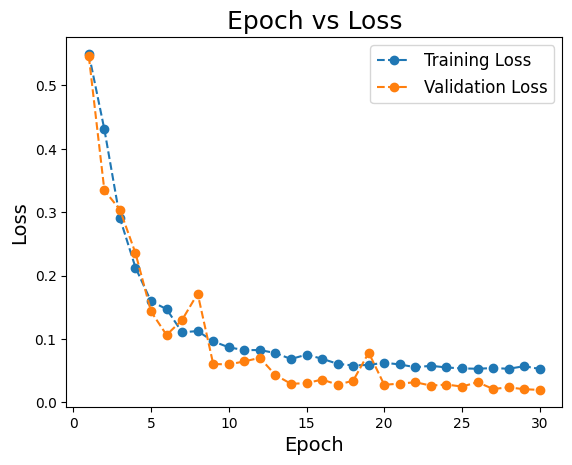

In [59]:
draw_plot(x_data = range(1, 31),
          y_data = [t_l, v_l],
          x_label = 'Epoch',
          y_label = 'Loss',
          legend_one = 'Training Loss',
          legend_two = 'Validation Loss',
          title = 'Epoch vs Loss')

In [60]:
for i in range(0,30):
  print(t_l[i],v_l[i])

0.5496501210259228 0.5457679828008016
0.4306661697422586 0.3345341583093007
0.2906406979735305 0.30388497312863666
0.21270644828313734 0.23545460402965546
0.15936389619984279 0.1433849756916364
0.14718650899282315 0.10631470506389935
0.11051491638872682 0.1301522726813952
0.11256345979324202 0.17158840472499529
0.09628939346932783 0.06059783697128296
0.08688077012576707 0.05985828364888827
0.08243583506200372 0.0646388487269481
0.08257347299921804 0.07029343023896217
0.07784740754017015 0.043129912888010345
0.0684136152267456 0.02935103823741277
0.07529781527090364 0.0303509005655845
0.0688606099021144 0.03604702278971672
0.06086006810570636 0.027943709244330723
0.05818310666193322 0.03420530383785566
0.05916786888932309 0.07840008661150932
0.06251065955474609 0.027765781929095585
0.059894284733184956 0.02964444023867448
0.05540591573751554 0.03179552840689818
0.05774753622528983 0.02649007613460223
0.05509199510987212 0.02814167986313502
0.05357696243175646 0.024988656242688496
0.0530

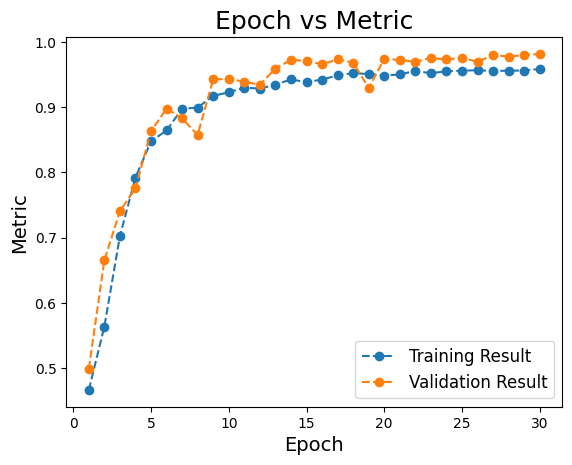

In [61]:
draw_plot(x_data = range(1, 31),
          y_data = [t_m, v_m],
          x_label = 'Epoch',
          y_label = 'Metric',
          legend_one = 'Training Result',
          legend_two = 'Validation Result',
          title = 'Epoch vs Metric')

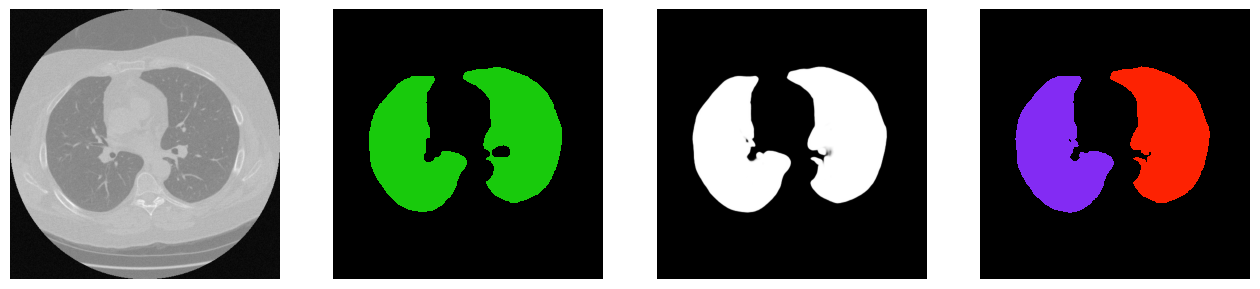

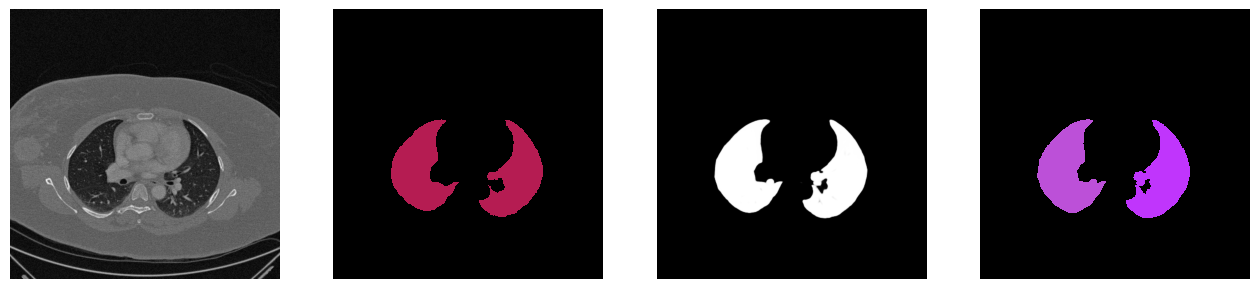

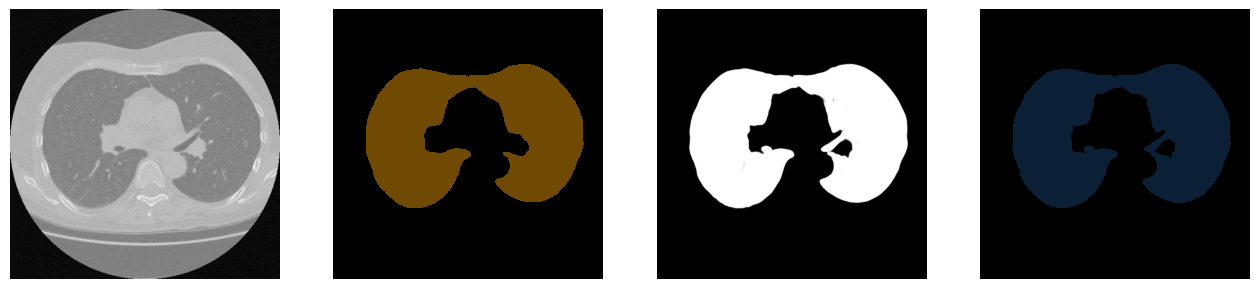

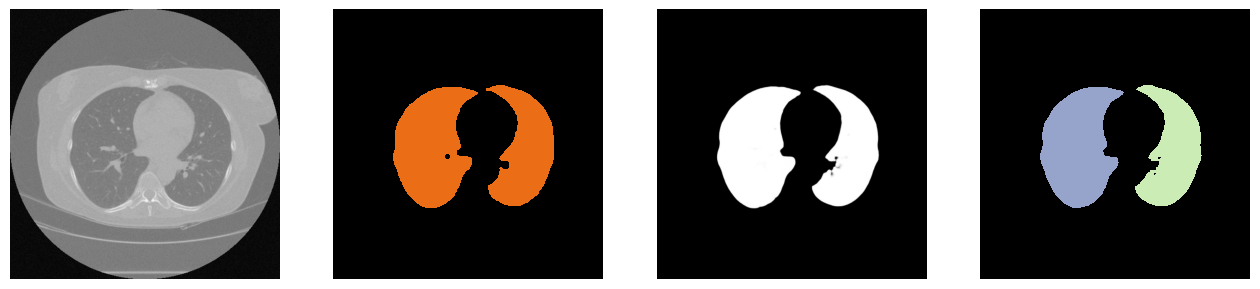

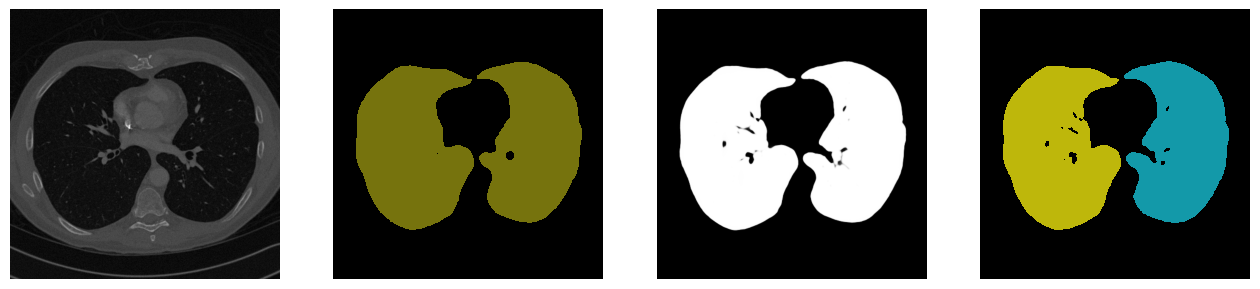

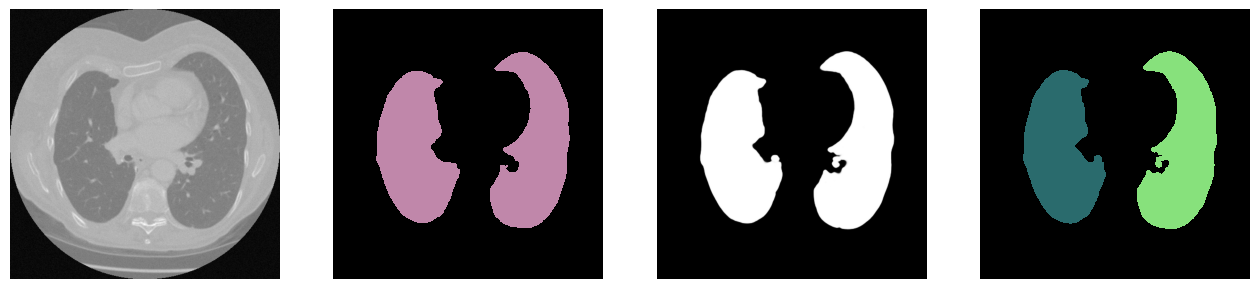

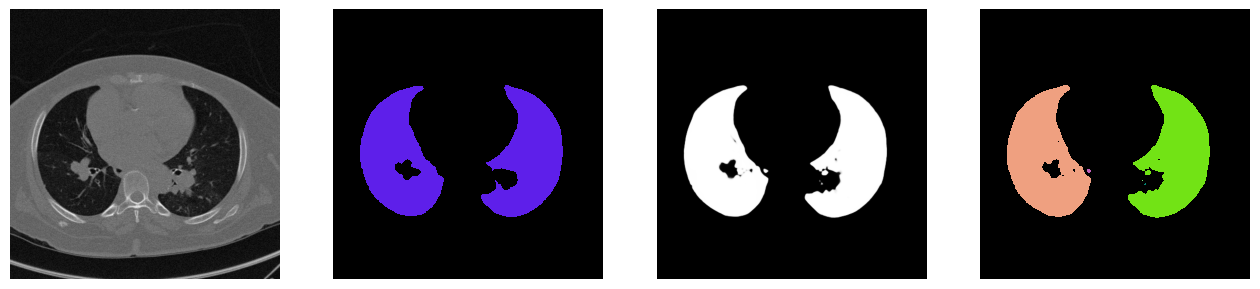

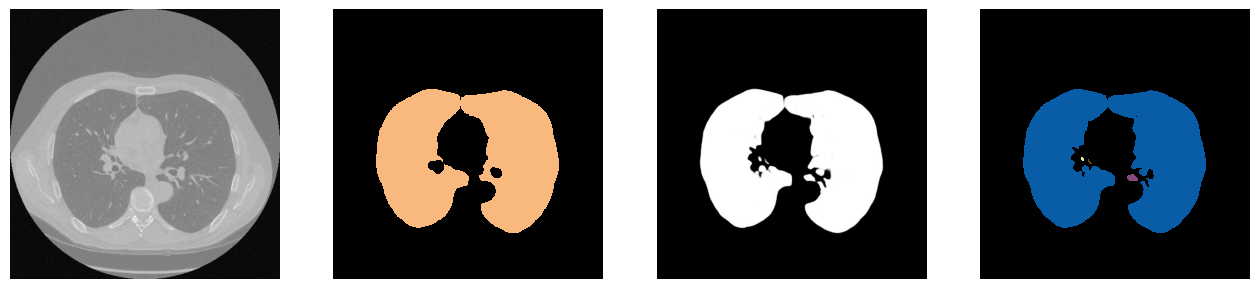

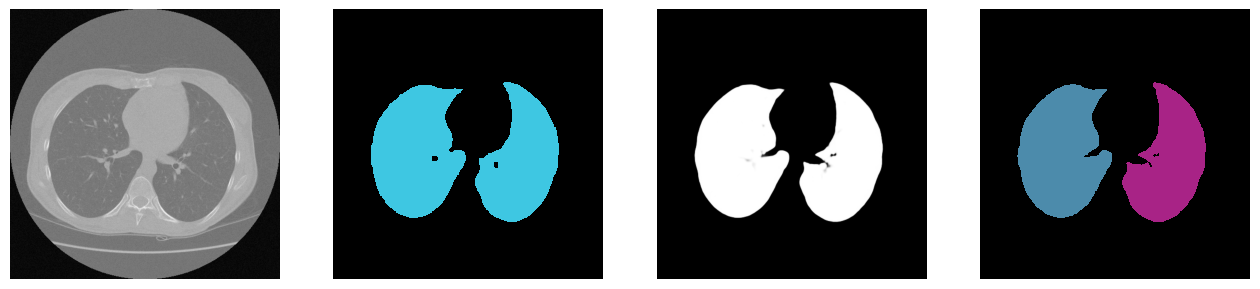

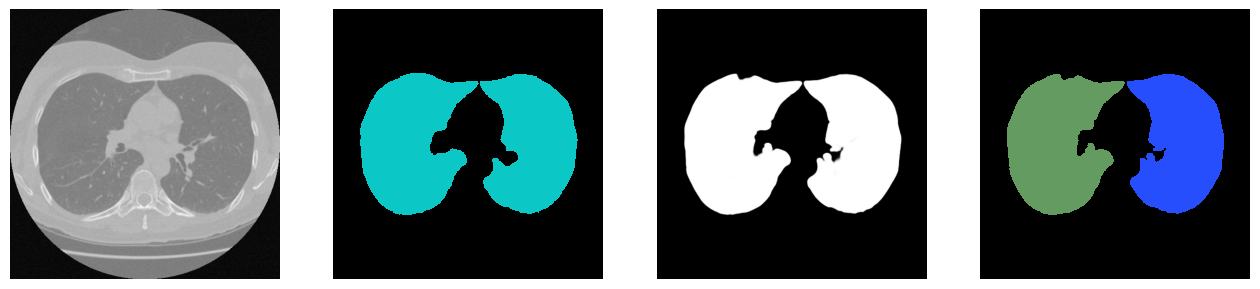

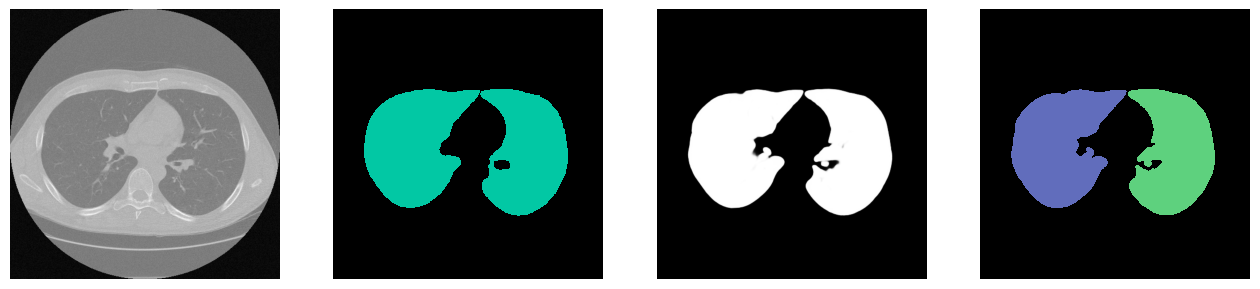

In [66]:
# check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in zip(test_images, test_masks):
        if counter > 10:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        im = im.astype(np.float32)
        # print(im.dtype)
        img = torch.from_numpy(im[None, None]).to(device)

        pred = model(img).squeeze()
        test = pred.cpu().detach().numpy()
        # print(im)
        # print(test)
        pred = torch.sigmoid(pred).cpu().numpy()
        # print(pred)
        # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        nuclei = label((pred > 0.5).astype(int))
        fig, ax = plt.subplots(1, 4, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im, cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
        ax[2].axis("off")
        ax[2].imshow(pred, cmap="gray")
        ax[3].axis("off")
        ax[3].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        plt.show()
        counter += 1

In [63]:
torch.save(model.state_dict(), 'model_final_1.h5')

In [64]:
# we also need a measure for the instance segmentation quality.
# here, we use intersection over union (for each ground-truth object).
# it is implemented for you already below

def precision(tp, fp, fn):
    return tp / (tp + fp) if tp > 0 else 0


def compute_ious(seg, mask):
    overlap = contingency_table(seg, mask).toarray()
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    eps = 1e-7
    ious = overlap / np.maximum(n_pixels_pred + n_pixels_true - overlap, eps)
    # ignore matches with zero (= background)
    ious = ious[1:, 1:]
    n_pred, n_true = ious.shape
    n_matched = min(n_pred, n_true)
    return n_true, n_matched, n_pred, ious


def compute_tps(ious, n_matched, threshold):
    not_trivial = n_matched > 0 and np.any(ious >= threshold)
    if not_trivial:
        # compute optimal matching with iou scores as tie-breaker
        costs = -(ious >= threshold).astype(float) - ious / (2*n_matched)
        pred_ind, true_ind = linear_sum_assignment(costs)
        assert n_matched == len(true_ind) == len(pred_ind)
        match_ok = ious[pred_ind, true_ind] >= threshold
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0
    return tp


def intersection_over_union(seg, mask, threshold=0.5):
    if seg.sum() == 0:
        return 0.0
    n_true, n_matched, n_pred, ious = compute_ious(seg, mask)
    tp = compute_tps(ious, n_matched, threshold)
    fp = n_pred - tp
    fn = n_true - tp
    ap = precision(tp, fp, fn)
    return ap

In [65]:
# Compute the average IOU of all the test images
ious = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # the model can only predict images with a spatial size that is divisible by 16
        # if it isn't we just cat a few pixels to make it fit
        im = im.astype(np.float32)
        crop_shape = (512, 512)
        shape = im.shape

        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            im, mask = im[crop], mask[crop]

        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.sigmoid(pred).cpu().view(512, 512).numpy()
        labels = label(pred > 0.5).astype(int)
        gt_mask = label(mask > 0.5).astype(int)
        iou = intersection_over_union(labels, gt_mask)
        ious.append(iou)
print()
print("Mean IoU:", np.mean(ious))

100%|██████████| 54/54 [00:05<00:00,  9.66it/s]


Mean IoU: 0.8493827160493826
